# Imports and Setups

In [0]:
# para ativar ambiente virtual: source venv/bin/activate
# pasta com os arquivos: cd dev/bracis/
# rodar jupyter: jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888   --NotebookApp.port_retries=0

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import time
import glob

# scikit
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

# keras
from keras.models import Model, Sequential
from keras import layers, regularizers, callbacks, utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model

#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

# nltk
import nltk
from nltk import word_tokenize, tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/caio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/caio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/caio/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
# testing if GPU available and if using CUDA
tf.test.is_gpu_available(
    cuda_only=True,
    min_cuda_compute_capability=None
)

True

In [0]:
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type == 'GPU']

num_gpu = len(get_available_gpus())
num_gpu

1

In [0]:
#folder setup

results_cnn = 'results/cnn/raw/emb_vader/'
results_svr = 'results/svr/raw/'
results_lstm = 'results/lstm/raw/'

resources = '../resources/'

if not os.path.isdir(results_cnn):
    ! mkdir -p $results_cnn
    ! mkdir -p $results_svr
    ! mkdir -p $results_lstm
    
if not os.path.isdir(resources):
    ! mkdir -p $resources

# Loading Dataset

In [0]:
# Loading training data
df_train = pd.read_json('Headline_Trainingdata.json')
df_train.head()

,company,id,sentiment,title
0,Morrisons,2,0.430,Morrisons book second consecutive quarter of s...
1,IMI,3,-0.344,IMI posts drop in first-quarter organic revenu...
2,Glencore,4,0.340,Glencore to refinance its short-term debt earl...
3,Ryanair,5,0.259,EasyJet attracts more passengers in June but s...
4,Barclays,6,-0.231,Barclays 'bad bank' chief to step down


In [0]:
n_bins = 9
# bins = df_train['sentiment'].quantile([0.1*q for q in range(0,n_bins)])
# df_train['quantile'] = pd.cut(df_train['sentiment'], bins=bins, labels=range(1,n_bins+1))
# df_train['quantile'] = pd.cut(df_train['sentiment'], bins=bins, include_lowest=True)

df_train['quantile'] = pd.qcut(df_train['sentiment'], q=n_bins, labels=range(1,n_bins+1))
df_train['quantile'].value_counts()

6    131
3    129
8    128
2    127
1    127
9    126
5    126
4    125
7    123
Name: quantile, dtype: int64

In [0]:
print('mean: {}; std: {}'.format(np.mean(df_train['sentiment']), np.std(df_train['sentiment'])))
# df_train['sentiment'].min()
# df_train['sentiment'].idxmin()
# df_train.iloc[20]

mean: 0.03104903677758319; std: 0.39360209451145045


In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

for fit_index, cv_index in skf.split(df_train, df_train['quantile']):
#   print("TRAIN:", train_index.size, "TEST:", test_index.size)
#   print("TRAIN:", train_index, "TEST:", test_index)
#   print("TRAIN:", df_train.iloc[train_index], "TEST:", df_train.iloc[test_index])
#   print('TRAIN: mean: {}; std: {}'.format(np.mean(df_train['sentiment'].iloc[train_index]), np.std(df_train['sentiment'].iloc[train_index])))
  print('df_train CV: mean: {}; std: {}'.format(np.mean(df_train['sentiment'].iloc[cv_index]), np.std(df_train['sentiment'].iloc[cv_index])))
#   df_train['sentiment'].iloc[test_index]
#   df_train.iloc[test_index]

df_train CV: mean: 0.03412017167381975; std: 0.38683983574619385
df_train CV: mean: 0.028765217391304363; std: 0.4037852384500579
df_train CV: mean: 0.029614035087719294; std: 0.3849741278336272
df_train CV: mean: 0.02813274336283186; std: 0.4028562295301328
df_train CV: mean: 0.03458666666666667; std: 0.3891696491534537


In [0]:
# Loading testing data, and removing normalizing collumns
df_test = pd.read_json("Headlines_Testdata_withscores.json")

df_test.drop('UniqueID', axis=1, inplace=True)
df_test.rename(columns={'sentiment score': 'sentiment'}, inplace=True)

df_test.head()

,company,id,sentiment,title
0,Ashtead,1144,0.588,"Ashtead to buy back shares, full-year profit b..."
1,Shell,1145,0.276,EU regulators clear Shell's takeover of BG Group
2,Prudential,1146,-0.651,UK's FTSE has worst day so far in 2015 as BG a...
3,GlaxoSmithKline,1147,0.390,GlaxoSmithKline acquires HIV assets
4,Barclays,1148,-0.834,Barclays faces another heavy forex fine


In [0]:
print('df_test: mean: {}; std: {}'.format(np.mean(df_test['sentiment']), np.std(df_test['sentiment'])))

df_test: mean: 0.014820773930753563; std: 0.4137897136769093


# Preprocessing

In [0]:
#stop words removal
def run_preprocessing(df):
  # replace company name by placeholder and remove double quotes that is not preprocessed well by word_tokenize
  # also lower casing words for compatilbility with glove, which only has lower casing words
  # be aware that some companies namies are not identical
  # example: id = 10 Centrica PLC appears as just Centrica on title
  title_company_replaced = df['title'].replace(df['company'], 'company', regex = True).replace('"', '', regex = True).str.lower()
#   title_company_replaced = df['title'].replace(df['company'], 'company', regex = True)

  # tokenize headlines
  tokenized_title = title_company_replaced.apply(word_tokenize)
  
  # removing stopwords and single quotes
  # stop_words: {'does', 'under', 'own', 'at', 'of', 'don', 'hers', 'further', 're', "you'll", 'into', 'she', 'such', 'shan', 'you', "haven't", 'when', 'me', 'a', 'all', "shan't", 'mustn', "should've", "didn't", "aren't", "weren't", 'after', 'ain', 's', "that'll", 'just', 'am', 'the', 'too', 'before', "wasn't", 'what', 'haven', 'm', 'up', 'against', 'how', 'who', 'yourselves', 'nor', 'than', 've', 'between', 'being', 'are', 'and', "don't", 'themselves', 'were', 'itself', 'd', 'doesn', 'there', "wouldn't", 'both', 'we', 'why', 'needn', 'those', 'out', 'mightn', 'which', 'it', 'here', 'theirs', 'any', 'my', 'that', "doesn't", 'should', 'him', 'weren', 'from', 'no', 'wouldn', 'once', 'with', 'will', 'have', 'is', 'most', 'hasn', 'll', 'yours', 'himself', 'was', 'this', 'or', 'over', 'again', 'y', 'do', 'through', "hasn't", "she's", 'same', 'down', 'has', 'so', 'can', 'shouldn', "hadn't", 'while', 'for', 'but', 'whom', "mustn't", 'our', 'if', "couldn't", "you've", 'be', 'been', 'myself', 'did', 'few', 'hadn', 'other', "you'd", 'not', 'ma', 'their', 'off', "shouldn't", 'had', 'these', 'his', 'yourself', 'very', "isn't", 'aren', 'o', 'won', 'because', 'isn', 'wasn', 'herself', 'by', 'where', 'your', 'i', "it's", 'above', 'until', "you're", 'they', 'only', 'ours', 'below', "mightn't", 'some', "won't", 'about', 'couldn', 'ourselves', 'them', 'he', 'during', 'more', 't', 'as', 'now', 'didn', "needn't", 'an', 'to', 'each', 'its', 'her', 'doing', 'then', 'on', 'in', 'having'}  
  # some of these word should probably not be removed like the word: won't
  # also maybe consider using TweetTokenizer, that mayy deal better with contactions like: Glencore's 
  stopwords_english = stopwords.words('english')
  stopwords_english.append('\'')

  df['clean_tokens'] = tokenized_title.apply(lambda x: [item.strip('\'') for item in x if item not in stopwords_english])
#   df['clean_tokens'] = tokenized_title.apply(lambda x: [item for item in x if item not in stopwords_english])
  df['new_title'] =  df['clean_tokens'].apply(lambda x: ' '.join(x))
  
run_preprocessing(df_train)
run_preprocessing(df_test)

df_test.head()

,company,id,sentiment,title,clean_tokens,new_title
0,Ashtead,1144,0.588,"Ashtead to buy back shares, full-year profit b...","[company, buy, back, shares, ,, full-year, pro...","company buy back shares , full-year profit bea..."
1,Shell,1145,0.276,EU regulators clear Shell's takeover of BG Group,"[eu, regulators, clear, company, s, takeover, ...",eu regulators clear company s takeover bg group
2,Prudential,1146,-0.651,UK's FTSE has worst day so far in 2015 as BG a...,"[uk, s, ftse, worst, day, far, 2015, bg, compa...",uk s ftse worst day far 2015 bg company fall
3,GlaxoSmithKline,1147,0.390,GlaxoSmithKline acquires HIV assets,"[company, acquires, hiv, assets]",company acquires hiv assets
4,Barclays,1148,-0.834,Barclays faces another heavy forex fine,"[company, faces, another, heavy, forex, fine]",company faces another heavy forex fine


## Tokenizing and Padding

In [0]:
clean_tokens_length = df_train["clean_tokens"].apply(lambda x: len(x))

max_sentence_length_train = np.max(clean_tokens_length)
min_sentence_length_train = np.min(clean_tokens_length)
mean_sentence_length_train = np.mean(clean_tokens_length)
std_sentence_length_train = np.std(clean_tokens_length)


print("max: {} | min: {} | mean: {} | std: {}".format(max_sentence_length_train, min_sentence_length_train, mean_sentence_length_train, std_sentence_length_train))

max: 16 | min: 3 | mean: 8.249562171628721 | std: 2.0743354560287957


In [0]:
# giving the max_sentence_length_train, we will use a number a little above
# TODO: evaluate if this is too much of a leakage, because each fold may yield different sequence MAX
MAX_SEQUENCE_LENGTH = 21

In [0]:
MAX_VOCAB_SIZE = 10000

# receives healines and returns tokenizer with vocab mappings and padded sentences read to use
def get_tok_sentences(doc_fit, doc_cv):
  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='', lower=False)
  tokenizer.fit_on_texts(doc_fit)

  fit_sentences = tokenizer.texts_to_sequences(doc_fit)
  cv_sentences = tokenizer.texts_to_sequences(doc_cv)
  
  fit_sentences_pad = pad_sequences(fit_sentences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
  cv_sentences_pad = pad_sequences(cv_sentences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

  return fit_sentences_pad, cv_sentences_pad, tokenizer

# sentences_seq_train, vocab_size, tokenizer = prepare_tokenizer(df_train)
# tokenizer.word_docs

In [0]:
# sentences_seq_train = pad_sequences(sentences_seq_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
# print(sentences_seq_train[1134, :])

In [0]:
#TODO: may be a good idea: FROM: https://www.tensorflow.org/tutorials/keras/basic_text_classification

# # A dictionary mapping words to an integer index
# word_index = imdb.get_word_index()

# # The first indices are reserved
# word_index = {k:(v+3) for k,v in word_index.items()} 
# word_index["<PAD>"] = 0
# word_index["<START>"] = 1
# word_index["<UNK>"] = 2  # unknown
# word_index["<UNUSED>"] = 3

# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# def decode_review(text):
#     return ' '.join([reverse_word_index.get(i, '?') for i in text])

# decode_review(train_data[0])


## Sentiment Dictionaries

### Loughran McDonald Dictionary

In [0]:
LMDDictionary = {}
vetor = []

# TODO: this can be done directly by converting to pandas and than calling the to_dict function
with open('LoughranMcDonald_MasterDictionary_2016.csv', 'r', encoding="utf8") as f:
    for line in f:
        palavra = line.split(',')[0].lower()
        vetor_char = line.split(',')[7:14]
        vetor = [1 if x!='0' else 0 for x in vetor_char]

        LMDDictionary[palavra] = np.asarray(vetor)

In [0]:
zeros = [0, 0, 0, 0, 0, 0, 0]
nan_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

def run_LMD(df):
  df['LMDVector'] = df['clean_tokens'].apply(lambda x: [LMDDictionary.get(item, zeros) for item in x])
  df['mean_LMD'] = df['LMDVector'].apply(lambda x: np.mean(x, axis=0, dtype=np.float64))
  
#   df['LMDVector'] = df['new_title'].apply(lambda x: [LMDDictionary.get(item, nan_list) for item in x]) #Taynan
#   df['mean_LMD'] = df['LMDVector'].apply(lambda x: np.nanmean(x, axis=0, dtype=np.float64)) #Taynan
  
run_LMD(df_train)
run_LMD(df_test)

df_train.head()

,company,id,sentiment,title,quantile,clean_tokens,new_title,LMDVector,mean_LMD
0,Morrisons,2,0.430,Morrisons book second consecutive quarter of s...,8,"[company, book, second, consecutive, quarter, ...",company book second consecutive quarter sales ...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,IMI,3,-0.344,IMI posts drop in first-quarter organic revenu...,2,"[company, posts, drop, first-quarter, organic,...",company posts drop first-quarter organic reven...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]"
2,Glencore,4,0.340,Glencore to refinance its short-term debt earl...,7,"[company, refinance, short-term, debt, early, ...","company refinance short-term debt early , shar...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,Ryanair,5,0.259,EasyJet attracts more passengers in June but s...,6,"[easyjet, attracts, passengers, june, still, l...",easyjet attracts passengers june still lags co...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Barclays,6,-0.231,Barclays 'bad bank' chief to step down,3,"[company, bad, bank, chief, step]",company bad bank chief step,"[[0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],...","[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### VADER

In [0]:
def run_sid(df):
  sid = SentimentIntensityAnalyzer()

  df['neu_VADER'] = df['clean_tokens'].apply(lambda x: [sid.polarity_scores(item)['neu'] for item in x])
  df['pos_VADER'] = df['clean_tokens'].apply(lambda x: [sid.polarity_scores(item)['pos'] for item in x])
  df['neg_VADER'] = df['clean_tokens'].apply(lambda x: [sid.polarity_scores(item)['neg'] for item in x])
  df['compound_VADER'] = df['clean_tokens'].apply(lambda x: [sid.polarity_scores(item)['compound'] for item in x])
  df['mean_VADER'] = df['new_title'].apply(lambda x: [v for k,v in sid.polarity_scores(x).items()])
  
#   df['neu_VADER'] = df['clean_tokens'].apply(lambda x: np.mean([sid.polarity_scores(item)['neu'] for item in x]))
#   df['pos_VADER'] = df['clean_tokens'].apply(lambda x: np.mean([sid.polarity_scores(item)['pos'] for item in x]))
#   df['neg_VADER'] = df['clean_tokens'].apply(lambda x: np.mean([sid.polarity_scores(item)['neg'] for item in x]))
#   df['compound_VADER'] = df['clean_tokens'].apply(lambda x: np.mean([sid.polarity_scores(item)['compound'] for item in x]))
#   df['mean_VADER'] = df[['neu_VADER', 'pos_VADER', 'neg_VADER', 'compound_VADER']].values.tolist()
  
                                 
run_sid(df_train)
run_sid(df_test)

df_train.head()
# np.mean(df_train['neu_VADER'])
# [np.mean(item) for item in df_train['neu_VADER']]

,company,id,sentiment,title,quantile,clean_tokens,new_title,LMDVector,mean_LMD,neu_VADER,pos_VADER,neg_VADER,compound_VADER,mean_VADER
0,Morrisons,2,0.430,Morrisons book second consecutive quarter of s...,8,"[company, book, second, consecutive, quarter, ...",company book second consecutive quarter sales ...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3818]","[0.0, 0.698, 0.302, 0.3818]"
1,IMI,3,-0.344,IMI posts drop in first-quarter organic revenu...,2,"[company, posts, drop, first-quarter, organic,...",company posts drop first-quarter organic reven...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, -0.2732, 0.0, 0.0, 0.0, 0.0, -0.102...","[0.333, 0.667, 0.0, -0.3612]"
2,Glencore,4,0.340,Glencore to refinance its short-term debt earl...,7,"[company, refinance, short-term, debt, early, ...","company refinance short-term debt early , shar...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, -0.3612, 0.0, 0.0, 0.296, 0.0]","[0.258, 0.515, 0.227, -0.0772]"
3,Ryanair,5,0.259,EasyJet attracts more passengers in June but s...,6,"[easyjet, attracts, passengers, june, still, l...",easyjet attracts passengers june still lags co...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.4019, 0.0, 0.0, 0.0, -0.3612, 0.0]","[0.245, 0.49, 0.265, 0.0516]"
4,Barclays,6,-0.231,Barclays 'bad bank' chief to step down,3,"[company, bad, bank, chief, step]",company bad bank chief step,"[[0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],...","[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, -0.5423, 0.0, 0.0, 0.0]","[0.467, 0.533, 0.0, -0.5423]"


### Both

In [0]:
def join_vader_LMD(df):
  df['mean_VADER_LMD'] = [np.hstack([x,y]) for x, y in zip(df['mean_LMD'], df['mean_VADER'])]

join_vader_LMD(df_train)
join_vader_LMD(df_test)

df_train.head()

,company,id,sentiment,title,quantile,clean_tokens,new_title,LMDVector,mean_LMD,neu_VADER,pos_VADER,neg_VADER,compound_VADER,mean_VADER,mean_VADER_LMD
0,Morrisons,2,0.430,Morrisons book second consecutive quarter of s...,8,"[company, book, second, consecutive, quarter, ...",company book second consecutive quarter sales ...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3818]","[0.0, 0.698, 0.302, 0.3818]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.698..."
1,IMI,3,-0.344,IMI posts drop in first-quarter organic revenu...,2,"[company, posts, drop, first-quarter, organic,...",company posts drop first-quarter organic reven...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, -0.2732, 0.0, 0.0, 0.0, 0.0, -0.102...","[0.333, 0.667, 0.0, -0.3612]","[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.333, 0.6..."
2,Glencore,4,0.340,Glencore to refinance its short-term debt earl...,7,"[company, refinance, short-term, debt, early, ...","company refinance short-term debt early , shar...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, -0.3612, 0.0, 0.0, 0.296, 0.0]","[0.258, 0.515, 0.227, -0.0772]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.258, 0.5..."
3,Ryanair,5,0.259,EasyJet attracts more passengers in June but s...,6,"[easyjet, attracts, passengers, june, still, l...",easyjet attracts passengers june still lags co...,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...","[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.4019, 0.0, 0.0, 0.0, -0.3612, 0.0]","[0.245, 0.49, 0.265, 0.0516]","[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Barclays,6,-0.231,Barclays 'bad bank' chief to step down,3,"[company, bad, bank, chief, step]",company bad bank chief step,"[[0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],...","[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, -0.5423, 0.0, 0.0, 0.0]","[0.467, 0.533, 0.0, -0.5423]","[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.467, 0.5..."


## TF-IDF

In [0]:
# def identity_tokenizer(doc):
#     return doc

# def get_tfidf(df):
#   tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word', lowercase=False)    
#   train_tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_tokens'])
  
#   return train_tfidf_matrix, tfidf_vectorizer

# train_tfidf_matrix, tfidf_vectorizer = get_tfidf(df_train)
# # print(tfidf_vectorizer.vocabulary_)

# feature_names = tfidf_vectorizer.get_feature_names()
# corpus_index = [n for n in df_train['title']]
# print(train_tfidf_matrix.T.todense().shape, len(feature_names), len(corpus_index))
# pd.DataFrame(train_tfidf_matrix.T.todense(), index=feature_names, columns=corpus_index)

In [0]:
# sid = SentimentIntensityAnalyzer()

# np.mean()

# df_train['clean_tokens'].apply(lambda x: [sid.polarity_scores(item)['neu'] for item in x])

## GloVe

In [0]:
# EMBEDDING_DIM = 300

# TODO: use: vocab_size = max(MAX_VOCAB_SIZE, len(word_index)) + 1

In [0]:
def load_embedding(emb_dim):
  
  # load the whole embedding into memory
  embeddings_index = dict()
  
  if not os.path.exists('resources/glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip -P /resources/
  if not os.path.exists('resources/glove.6B.' + str(emb_dim) + 'd.txt'):
    ! unzip resources/glove.6B.zip -d resources
  
  f = open('resources/glove.6B.' + str(emb_dim) + 'd.txt', 'r', encoding="utf8")
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  
  return embeddings_index

In [0]:
# create a weight matrix for words in training docs
def get_embedding_matrix(emb_dim, vocab_size, input_length, tokenizer, embeddings_index):
  vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index)) + 1 # Adding 1 because of reserved 0 index
  embedding_matrix = np.zeros((vocab_size, emb_dim))
  for word, i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if (embedding_vector is not None):
          embedding_matrix[i] = embedding_vector

  return embedding_matrix


# banna, maca, tokenizer = get_tok_sentences(df_train['new_title'], df_test['new_title'])
# get_embedding_matrix(300, MAX_VOCAB_SIZE, True, MAX_SEQUENCE_LENGTH, tokenizer).shape[0]

# Models

## CNN Model

In [0]:
def cos_sim(y_true, y_pred):
#   x = K.l2_normalize(y_true, axis=-1)
#   y = K.l2_normalize(y_pred, axis=-1)
#   return K.mean(x * y, axis=-1, keepdims=True)
  return cosine_similarity(y_true, y_pred)

metrics = ['cosine_proximity']
# dropout = 0.3
# loss = 'mse'

In [0]:
# callback for time: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
# or maybe just use keras LambdaCallback

class TimeHistory(callbacks.Callback):  
  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    logs['time_passed'] = time.time() - self.epoch_time_start

def callback_functions(nome_log):
  time_callback = TimeHistory()
  csv_logger = callbacks.CSVLogger(results_cnn + nome_log + '.csv', separator=';', append=True)
#     tensorboard_callback = callbacks.TensorBoard(nome_log, histogram_freq=1)
#     best_model = callbacks.ModelCheckpoint(results_cnn + nome_log + '.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

  return [time_callback, csv_logger]

In [0]:
def create_model_2Conv_1Dense(num_filters_1, num_filters_2, size_filters_1, size_filters_2, number_dense, dropout_value, embedding_matrix, emb_layer_trainable):
    
    # first input model
    visible1 = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Word_Seq')
    embedding = layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=emb_layer_trainable)(visible1)
#     embedding = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)(visible1)
#     embedding = embedding_layer(visible1)
    conv1 = layers.Conv1D(num_filters_1, size_filters_1, padding='same', activation='relu')(embedding)
    conv2 = layers.Conv1D(num_filters_2, size_filters_2, padding='same', activation='relu')(conv1)
    pool1 = layers.GlobalMaxPooling1D()(conv2)
    flat1 = pool1
    
    # second input model
#     visible2 = layers.Input(shape=(np.array(df_train['mean_VADER_LMD'].tolist()).shape[1],), name='Lexical')
    visible2 = layers.Input(shape=(np.array(df_train['mean_VADER'].tolist()).shape[1],), name='Lexical')
    flat2 = visible2

    # merge input models
    merge = layers.concatenate([flat1, flat2])
#     merge = flat1
    
    # interpretation model
    dropout1 = layers.Dropout(dropout_value)(merge)
#     dropout1 = layers.Dropout(dropout_value)(flat1)
    hidden1 = layers.Dense(number_dense, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
    dropout2 = layers.Dropout(dropout_value)(hidden1)
    output = layers.Dense(1, activation='tanh')(dropout2)
    model = Model(inputs=[visible1, visible2], outputs=output)
#     model = Model(inputs=[visible1], outputs=output)

    return model

In [0]:
def train_model(model, X, Y, batch_size, epochs_value, nome_log, X_cv, Y_cv):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics)
    
    return model.fit(X, Y, batch_size,
                     validation_data=(X_cv, Y_cv),
                     epochs=epochs_value,
                     verbose=0,
                     callbacks=callback_functions(nome_log)
                    )

In [0]:
def save_model(model, trained_model_history, model_name):
    
#     model.save(model_name + '.h5')
    trained_model = trained_model_history
    
    plt.figure(1)
    plt.plot([abs(v) for v in trained_model.history['loss']])
    plt.plot([abs(v) for v in trained_model.history['val_loss']])
    plt.plot([abs(v) for v in trained_model.history['cosine_proximity']])
    plt.plot([abs(v) for v in trained_model.history['val_cosine_proximity']])
    plt.title('model mean squared error')
    plt.ylabel('mean squared error')
    plt.xlabel('epoch')
    plt.legend(['mse_train', 'mse_test', 'cos_sim_train', 'cos_sim_test'], loc='upper left')
    plt.savefig(results_cnn + model_name + '_mse.png')
    plt.close()

In [0]:
def evaluate_model(model, X, Y_expected):
    input = X
    output = np.array(model.predict(input))
    expected = np.array(Y_expected)

    dot = np.dot(expected, output)
    output_mod = np.linalg.norm(output)
    expected_mod = np.linalg.norm(expected)
    cos = dot / output_mod / expected_mod

    final_score = cos
    
    return final_score

## K-fold on Train

In [0]:
kfold_id = 10000

resumo = pd.DataFrame(columns=['kfold_id','cos_sim_mean','cos_sim_std','mse_mean','mse_std','training_time','batch_size','num_filters','size_filters','num_dense','dropout'])

number_epochs = 30

tokenizer_kfold = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='', lower=False)
tokenizer_kfold.fit_on_texts(df_train['new_title'])

for emb_dim in [300, 200, 100, 50]:
  
  embeddings_index_kfold = load_embedding(emb_dim)
  
  for batch_size in [32, 64]:
      for num_filters in [384, 256, 128]:
          for size_filters in [4, 3, 2]:
              for number_dense in [150, 100, 50]:
                  for dropout_value in [0.3, 0.4, 0.5]:

                    cvscores_mse = []
                    cvscores_cos_sim = []
                    time_list = []
                    
                    seed = 42
                    np.random.seed(seed)
                    
                    for train, val in skf.split(df_train, df_train['quantile']):
#                         print(train)
                        X_train = df_train.iloc[train]
                        X_val = df_train.iloc[val]
    
                        Y_train = df_train['sentiment'].iloc[train]
                        Y_val = df_train['sentiment'].iloc[val]
                
                        # get sentences ready for usage
                        sentences_train_pad, sentences_val_pad, tok_kfold = get_tok_sentences(X_train["new_title"], X_val["new_title"])
                  
                        embedding_matrix = get_embedding_matrix(emb_dim, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, tok_kfold, embeddings_index_kfold)
                        
#                         nn_input_train = {'Word_Seq': sentences_train_pad, 'Lexical': np.array(X_train['mean_VADER_LMD'].tolist())}
#                         nn_input_val = {'Word_Seq': sentences_val_pad, 'Lexical': np.array(X_val['mean_VADER_LMD'].tolist())}
                        nn_input_train = {'Word_Seq': sentences_train_pad, 'Lexical': np.array(X_train['mean_VADER'].tolist())}
                        nn_input_val = {'Word_Seq': sentences_val_pad, 'Lexical': np.array(X_val['mean_VADER'].tolist())}
                      
                        model_name = 'kfoldid_' + str(kfold_id) + '-dim_' + str(emb_dim) + '-bs_' + str(batch_size) + '-nf_' + str(num_filters) + '-sf_' + str(size_filters) + '-nd_' + str(number_dense) + '-dv_' + str(10*dropout_value)
    
                        cnn = create_model_2Conv_1Dense(num_filters, num_filters, size_filters, size_filters, number_dense, dropout_value, embedding_matrix, True)

                        init = datetime.datetime.now()
                        trained = train_model(cnn, nn_input_train, Y_train, batch_size, number_epochs, model_name, nn_input_val, Y_val)
                        training_time = (datetime.datetime.now() - init)
                        cvscores_mse.append(trained.history['val_loss'][-1])
                        cvscores_cos_sim.append(-trained.history['val_cosine_proximity'][-1])
                        time_list.append(training_time)
                        # save_model(cnn, trained, model_name)
                  
                        if K.backend() == 'tensorflow':
                          K.clear_session()

                    result = [kfold_id, np.mean(cvscores_cos_sim), np.std(cvscores_cos_sim), np.mean(cvscores_mse), np.std(cvscores_mse), np.mean(time_list), batch_size, num_filters, size_filters,  number_dense, dropout_value]
                    resumo = resumo.append(pd.Series(result, index=resumo.columns), ignore_index=True)

                    print('ID: {}, Cos Sim Mean: {}, Cos Sim Std: {}, MSE Mean: {}, MSE Std: {}, Training Time: {}, Batch: {}, Num Filters: {}, Size Filters:{}, Num Dense: {}, Dropout: {}'.format(*result))
                    
                    kfold_id = kfold_id + 1

In [0]:
melhores = resumo.sort_values('mse_mean', ascending=True)
melhores

In [0]:
# melhores.to_csv(results_cnn + 'resumo/' + 'Resultados10.csv', sep='\t', encoding='utf-8')

In [0]:
# seed = 42
# np.random.seed(seed)

# i = 1000
# resumo = pd.DataFrame({'ID': 0, 'Batch Size': 0, 'Number Filters': 0, 'Size Filters': 0, 'Number Dense': 0, 'Dropout': 0.0, 'Score Mean': 0.0, 'Std': 0.0, 'Training Time': (datetime.datetime.now() - datetime.datetime.now())}, index=[0])

# X = {'Word_Seq': sentences_seq_train, 'Lexical': np.array(df_train['mean_VADER'].tolist())}
# Y = df_train['sentiment']

# number_folds = 5

# for batch_size in [64]:
#     for num_filters in [256, 128, 64]:
#         for size_filters in [2, 3, 4]:
#             for number_dense in [150, 100, 50]:
#                 for dropout_value in [0.4, 0.3]:
                    
#                     kfold = KFold(n_splits=number_folds)
#                     cvscores = []
#                     time = []
                    
#                     for train, valid in skf.split(df_train['Word_Seq'], df_train['quantile']):
#                         model_name = str(i) + '-bs_' + str(batch_size) + '-nf_' + str(num_filters) + '-sf_' + str(size_filters) + '-nd_' + str(number_dense) + '-dv_' + str(10*dropout_value)
#                         cnn = create_model_2Conv_1Dense(num_filters, num_filters, size_filters, size_filters, number_dense, dropout_value)

#                         init = datetime.datetime.now()
#                         trained = train_model(cnn, [X['Word_Seq'][train], X['Lexical'][train]], Y[train], batch_size, 25, model_name)
#                         training_time = (datetime.datetime.now() - init)
#                         performance = evaluate_model(cnn, [X['Word_Seq'][valid], X['Lexical'][valid]], Y[valid])
#                         cvscores.append(performance)
#                         time.append(training_time)

#                     #save_model(cnn, trained, model_name)
#                     result = pd.DataFrame({'ID': i, 'Batch Size': batch_size, 'Number Filters': num_filters, 'Size Filters': size_filters, 'Number Dense': number_dense, 'Dropout': dropout_value, 'Score Mean': np.mean(cvscores), 'Std': np.std(cvscores), 'Training Time': np.mean(time)}, index=[0])
#                     resumo = resumo.append(result, ignore_index=True)

#                     print('ID: ' + str(i) + ', Batch Size: ' + str(batch_size) + ', Number Filters: ' + str(num_filters) + ', Size Filters:' + str(size_filters) + ', Number Dense: ' + str(number_dense) + ', Dropout: ' + str(dropout_value) + ', Score Mean: ' + str(np.mean(cvscores)) + ', Std: ' + str(np.std(cvscores)) + ', Training Time: ' + str(np.mean(time)))

#                     i = i + 1

In [0]:
# melhores = resumo.sort_values('Score Mean', ascending=False)
# melhores

In [0]:
# melhores.to_csv('Resultados3.csv', sep='\t', encoding='utf-8')

### Results Processing

In [0]:
# specifying results filepath dest file
results_filepath = 'results/cnn/emb_vader-5-fold-v2.csv'

In [0]:
# this function goes through all csv results process and group them together
def process_raw_data(results_filepath):
  all_files = glob.glob(results_cnn + "*.csv")
#   all_files = glob.glob(results_cnn + "kfoldid_10000-dim_300-bs_32-nf_384-sf_4-nd_150-dv_3.0.csv")

  li = []
  
  for filename in all_files:
    # 1) we process the filename which has info in itself
    params_raw = filename.strip(results_cnn).strip('.csv').split('-')
    
    params_dict = dict()

    for param in params_raw:
      key, value = param.split('_')
      if key == 'dv':
        params_dict[key] = float(value) / 10 
      else:
        params_dict[key] = int(value)
      
    df_params = pd.DataFrame(params_dict, index=[0])
    df_params.columns = ['kfold_id','emb_dim','batch_size','num_filters','size_filters','num_dense','dropout']

    # 2) we process the content inside the file
    df_results = pd.read_csv(filename, index_col=None, header=0, sep=';')
    df_results = df_results.groupby(['epoch'], as_index=False).mean().join(df_results.groupby(['epoch']).std(), lsuffix='_mean', rsuffix='_std')
    
    # 2.1) Converting negative values to positives
    df_results['cosine_proximity_mean'] = abs(df_results['cosine_proximity_mean'])
    df_results['val_cosine_proximity_mean'] = abs(df_results['val_cosine_proximity_mean'])
  
    # 2.2) Defining row with best value
    df_results['best_val_loss_mean'] = False
    df_results['best_val_cosine_proximity_mean'] = False
  
    best_val_loss_mean = df_results['val_loss_mean'].min()
    best_val_cosine_proximity_mean = df_results['val_cosine_proximity_mean'].max()
  
    df_results.loc[df_results['val_loss_mean'] == best_val_loss_mean, 'best_val_loss_mean'] = True
    df_results.loc[df_results['val_cosine_proximity_mean'] == best_val_cosine_proximity_mean, 'best_val_cosine_proximity_mean'] = True

    # 3) we join all info together
    df_processed = df_params.join(df_results, how='right').ffill()
    
    # 4) changing some of the collumns to int
    df_processed[['kfold_id','emb_dim','batch_size','num_filters','size_filters','num_dense']] = df_processed[['kfold_id','emb_dim','batch_size','num_filters','size_filters','num_dense']].astype('int64')
    
    li.append(df_processed)
    
  df_final = pd.concat(li, axis=0, ignore_index=True)
  
  df_final.to_csv(results_filepath, index=False, sep=',', encoding='utf-8')
  
process_raw_data(results_filepath)

## Treinando em todo o conjunto de Treino e avaliando no conjunto de Teste

In [0]:
# selecting best models
df_results = pd.read_csv(results_filepath)

best_mse_model = df_results[df_results['best_val_loss_mean'] == True].sort_values(by=['val_loss_mean']).iloc[0]
best_cos_model = df_results[df_results['best_val_cosine_proximity_mean'] == True].sort_values(by=['val_cosine_proximity_mean'], ascending=[False]).iloc[0]

# best_cos_model[['emb_dim', 'num_filters', 'size_filters', 'num_dense', 'dropout', 'epoch', 'batch_size']]
best_mse_model

kfold_id                                10024
emb_dim                                   300
batch_size                                 32
num_filters                               384
size_filters                                2
num_dense                                  50
dropout                                   0.3
epoch                                      26
cosine_proximity_mean                0.919867
loss_mean                           0.0103265
time_passed_mean                    0.0887762
val_cosine_proximity_mean            0.516975
val_loss_mean                       0.0846678
cosine_proximity_std               0.00711316
loss_std                          0.000826094
time_passed_std                    0.00465413
val_cosine_proximity_std            0.0421538
val_loss_std                       0.00570084
best_val_loss_mean                       True
best_val_cosine_proximity_mean          False
Name: 3116, dtype: object

In [0]:
def run_final_test(best_model_config, eval_type):

  # fix random seed for reproducibility
  seed = 42
  np.random.seed(seed)

  emb_dim, num_filters, size_filters, num_dense, dropout, epoch, batch_size = best_model_config[['emb_dim', 'num_filters', 'size_filters', 'num_dense', 'dropout', 'epoch', 'batch_size']]

  embeddings_index_final = load_embedding(emb_dim)

  sentences_train_final_pad, sentences_test_final_pad, tok_final = get_tok_sentences(df_train["new_title"], df_test["new_title"])

  # X = {'Word_Seq': sentences_train_final_pad, 'Lexical': np.array(df_train['mean_VADER_LMD'].tolist())}
  X = {'Word_Seq': sentences_train_final_pad, 'Lexical': np.array(df_train['mean_VADER'].tolist())}
  # X = {'Word_Seq': sentences_train_final_pad}
  Y = df_train['sentiment']

  embedding_matrix = get_embedding_matrix(emb_dim, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, tok_final, embeddings_index_final)

  # cnn = create_model_2Conv_1Dense(256, 256, 2, 2, 150, 0.4, embedding_matrix, True)
  # cnn = create_model_2Conv_1Dense(128, 128, 3, 3, 50, 0.5, embedding_matrix, True)
#   cnn = create_model_2Conv_1Dense(384, 384, 3, 3, 150, 0.3, embedding_matrix, True)
  cnn = create_model_2Conv_1Dense(num_filters, num_filters, int(size_filters), int(size_filters), num_dense, dropout, embedding_matrix, True)
  trained = train_model(cnn, X, Y, batch_size, epoch, 'main_data_test', X, Y)
#   trained = train_model(cnn, X, Y, 32, 15, 'main_data_test', X, Y)
  # cnn = True
  # trained =  True
  
  
  # X_test = {'Word_Seq': sentences_seq_test, 'Lexical': np.array(df_test['mean_VADER_LMD'].tolist())}
  X_test = {'Word_Seq': sentences_test_final_pad, 'Lexical': np.array(df_test['mean_VADER'].tolist())}
  # X_test = {'Word_Seq': sentences_seq_test}

  if eval_type == 'cos_sim':
    y_pred = cnn.predict(X_test)
    return cosine_similarity(y_pred.reshape(1, -1), df_test['sentiment'].values.reshape(1, -1))
  else:
    return cnn.evaluate(X_test, df_test['sentiment'])

In [0]:
final_mse_score = run_final_test(best_mse_model, 'mse')
# final_cos_score = run_final_test(best_mse_model, 'cos_sim')

print(final_mse_score)
# print('Cos_sim: {}'.format(final_cos_score))

<Figure size 432x288 with 0 Axes>

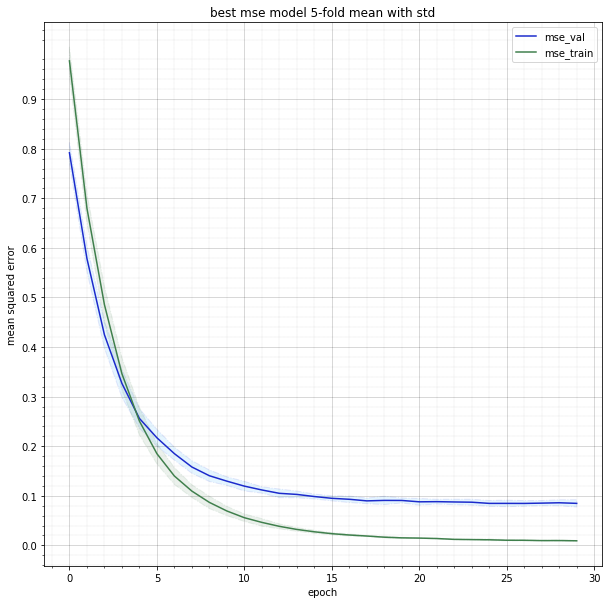

In [0]:
# these plot functions really need a clean up, this code is terrible...
def generate_plot():
  results_filepath = 'results/cnn/emb_vader-5-fold-mse.png'

  
  
  df_plot = df_results[df_results['kfold_id'] == best_mse_model['kfold_id']].sort_values(by='epoch', ascending=True)
  
#   print(df_plot)
  
#   pl.plot(x, y, 'k', color='#1B2ACC')
# pl.fill_between(x, y-error, y+error,
#     alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#     linewidth=4, linestyle='dashdot', antialiased=True)
  
  error = df_plot['val_loss_std']
  x = df_plot['epoch']
  y = df_plot['val_loss_mean']
  
  y_loss = df_plot['loss_mean']
  error_loss = df_plot['loss_std']
  
  plt.clf()

  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.set_yticks(np.arange(0, 1.0, 0.1))
  
  # Customize the minor grid
  ax.minorticks_on()
  ax.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
  
  plt.plot(x, y, 'k', color='#1B2ACC', markersize=30)
#   plt.plot(x, y, 'k', color='#1B2ACC')
  plt.fill_between(x, y-error, y+error, alpha=0.1, edgecolor='#1B2ACC', facecolor='#089FFF', linestyle='dashdot', linewidth=1, antialiased=True)
#   plt.plot([abs(v) for v in trained_model.history['val_loss']])
#   plt.plot([abs(v) for v in trained_model.history['cosine_proximity']])
#   plt.plot([abs(v) for v in trained_model.history['val_cosine_proximity']])
  plt.title('best mse model 5-fold mean with std')
  plt.ylabel('mean squared error')
  plt.xlabel('epoch')
#   plt.figure(figsize=(10,10))
#   plt.legend(['mse_train', 'mse_test', 'cos_sim_train', 'cos_sim_test'], loc='upper left')

  plt.grid(True, 'major', ls='-', lw=.5, c='k', alpha=.3)
 
  plt.plot(x, y_loss, 'k', color='#3F7F4C', markersize=30)
#   plt.plot(x, y, 'k', color='#1B2ACC')
  plt.fill_between(x, y_loss-error_loss, y_loss+error_loss, alpha=0.1, edgecolor='#3F7F4C', facecolor='#3F7F4C', linestyle='dashdot', linewidth=1, antialiased=True)

  plt.legend(['mse_val', 'mse_train'], loc='upper right')
  
  plt.savefig(results_filepath, dpi = 100)
  plt.show()
  plt.close()
  
generate_plot()

<Figure size 432x288 with 0 Axes>

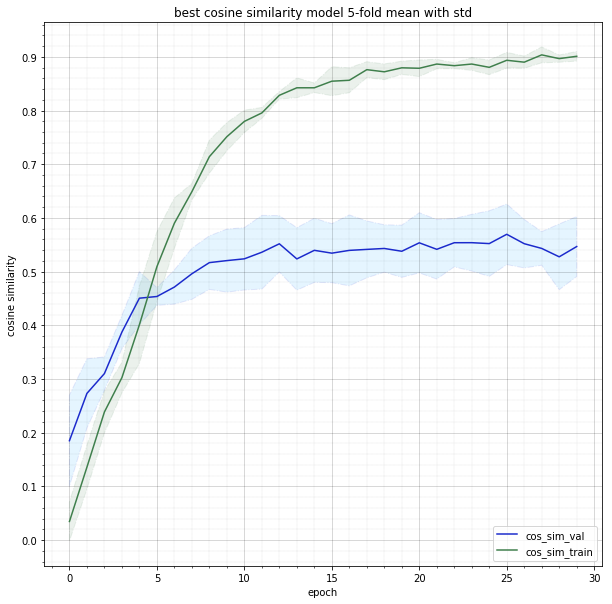

In [0]:
def generate_plot():
  results_filepath = 'results/cnn/emb_vader-5-fold-cos_sim.png'
  
  df_plot = df_results[df_results['kfold_id'] == best_cos_model['kfold_id']].sort_values(by='epoch', ascending=True)
  
#   print(df_plot)
  
#   pl.plot(x, y, 'k', color='#1B2ACC')
# pl.fill_between(x, y-error, y+error,
#     alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#     linewidth=4, linestyle='dashdot', antialiased=True)
  
  error = df_plot['val_cosine_proximity_std']
  x = df_plot['epoch']
  y = df_plot['val_cosine_proximity_mean']
  
  y_loss = df_plot['cosine_proximity_mean']
  error_loss = df_plot['cosine_proximity_std']
  
  plt.clf()
  
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.set_yticks(np.arange(0, 1.0, 0.1))
  
  # Customize the minor grid
  ax.minorticks_on()
  ax.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
  
  plt.plot(x, y, 'k', color='#1B2ACC', markersize=30)
#   plt.plot(x, y, 'k', color='#1B2ACC')
  plt.fill_between(x, y-error, y+error, alpha=0.1, edgecolor='#1B2ACC', facecolor='#089FFF', linestyle='dashdot', linewidth=1, antialiased=True)
#   plt.plot([abs(v) for v in trained_model.history['val_loss']])
#   plt.plot([abs(v) for v in trained_model.history['cosine_proximity']])
#   plt.plot([abs(v) for v in trained_model.history['val_cosine_proximity']])
  plt.title('best cosine similarity model 5-fold mean with std')
  plt.ylabel('cosine similarity')
  plt.xlabel('epoch')
#   plt.figure(figsize=(10,10))
#   plt.legend(['mse_train', 'mse_test', 'cos_sim_train', 'cos_sim_test'], loc='upper left')

  plt.grid(True, 'major', ls='-', lw=.5, c='k', alpha=.3)
 
  plt.plot(x, y_loss, 'k', color='#3F7F4C', markersize=30)
#   plt.plot(x, y, 'k', color='#1B2ACC')
  plt.fill_between(x, y_loss-error_loss, y_loss+error_loss, alpha=0.1, edgecolor='#3F7F4C', facecolor='#3F7F4C', linestyle='dashdot', linewidth=1, antialiased=True)

  plt.legend(['cos_sim_val', 'cos_sim_train'], loc='lower right')
  
  plt.savefig(results_filepath, dpi = 100)
  plt.show()
  plt.close()
#   plt.figure(figsize=(100000,100000))
#   plt.show()
  
generate_plot()

In [0]:
# plt.figure(1)
# plt.plot([abs(v) for v in trained_model.history['loss']])
# plt.plot([abs(v) for v in trained_model.history['val_loss']])
# plt.plot([abs(v) for v in trained_model.history['cosine_proximity']])
# plt.plot([abs(v) for v in trained_model.history['val_cosine_proximity']])
# plt.title('model mean squared error')
# plt.ylabel('mean squared error')
# plt.xlabel('epoch')
# plt.legend(['mse_train', 'mse_test', 'cos_sim_train', 'cos_sim_test'], loc='upper left')
# plt.savefig(results_cnn + model_name + '_mse.png')
# plt.close()

In [0]:
# input = X
# output = np.array(cnn.predict(input))
# expected = np.array(Y)

In [0]:
# plt.figure(1)
# plt.plot(output[0:50])
# plt.plot(expected[0:50])
# plt.title('Performance')
# plt.ylabel('Y')
# plt.xlabel('X')
# plt.legend(['predicted', 'expected'], loc='upper left')
# plt.savefig(results_cnn + 'avaliacao_performance.png')
# plt.close()